In [69]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_palette("Set2")
import matplotlib.pyplot as plt

In [70]:
df = pd.read_csv('./datasets/Data_Cortex_Nuclear.csv', index_col=0)

In [71]:
df.shape

(1080, 81)

In [72]:
df.head()

,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,...,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class
MouseID,,,,,,,,,,,,,,,,,,,,,
309_1,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,1.750936,...,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652,Control,Memantine,C/S,c-CS-m
309_2,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,1.596377,...,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610,Control,Memantine,C/S,c-CS-m
309_3,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,1.561316,...,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427,Control,Memantine,C/S,c-CS-m
309_4,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,1.595086,...,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563,Control,Memantine,C/S,c-CS-m
309_5,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,1.504230,...,0.110694,0.434154,0.118481,0.140314,0.148380,1.839730,Control,Memantine,C/S,c-CS-m


In [73]:
df_X = df.drop(['Genotype', 'Treatment', 'Behavior', 'class'], axis=1, inplace=False).copy()

# 1. EDA

In [74]:
df_X.describe().T

,count,mean,std,min,25%,50%,75%,max
DYRK1A_N,1077.0,0.425810,0.249362,0.145327,0.288121,0.366378,0.487711,2.516367
ITSN1_N,1077.0,0.617102,0.251640,0.245359,0.473361,0.565782,0.698032,2.602662
BDNF_N,1077.0,0.319088,0.049383,0.115181,0.287444,0.316564,0.348197,0.497160
NR1_N,1077.0,2.297269,0.347293,1.330831,2.057411,2.296546,2.528481,3.757641
NR2A_N,1077.0,3.843934,0.933100,1.737540,3.155678,3.760855,4.440011,8.482553
...,...,...,...,...,...,...,...,...
SYP_N,1080.0,0.446073,0.066432,0.258626,0.398082,0.448459,0.490773,0.759588
H3AcK18_N,900.0,0.169609,0.059402,0.079691,0.125848,0.158240,0.197876,0.479763
EGR1_N,870.0,0.183135,0.040406,0.105537,0.155121,0.174935,0.204542,0.360692
H3MeK4_N,810.0,0.205440,0.055514,0.101787,0.165143,0.193994,0.235215,0.413903


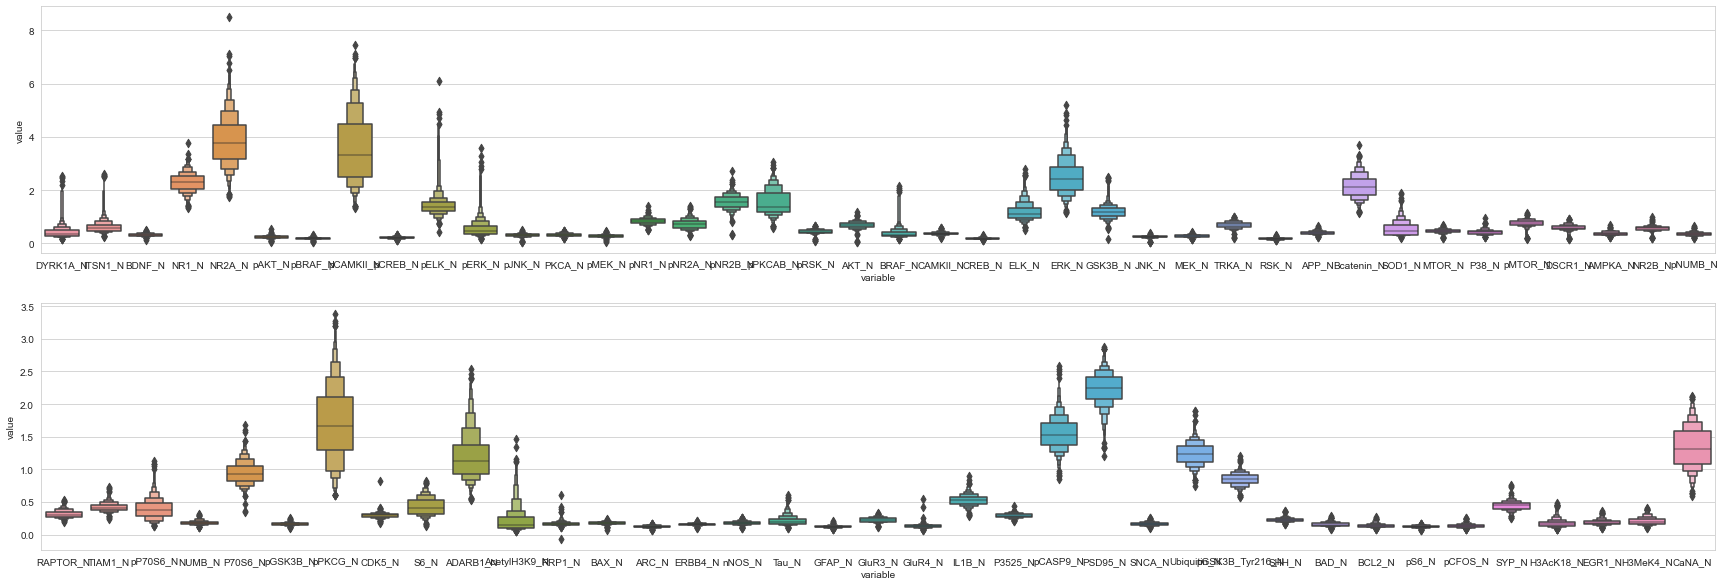

In [75]:
_, axs = plt.subplots(2, 1, figsize=(30, 10))
sns.boxenplot(data=pd.melt(df_X.iloc[:, :40]), x='variable', y='value', ax=axs[0])
sns.boxenplot(data=pd.melt(df_X.iloc[:, 40:]), x='variable', y='value', ax=axs[1])
plt.show()

## 1.1 Univariate Outliers

In [76]:
def count_outliers(df):
    Q1, Q3 = df.quantile(0.25), df.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = {col:0 for col in df.columns}
    for col in df.columns:
        outliers[col] += np.sum(((df[col] < lower_bound[col]) | (df[col] > upper_bound[col])))
    return pd.Series(outliers)

In [77]:
outluers_counts = count_outliers(df_X)
outluers_counts[outluers_counts > 0].sort_values(ascending=False)

AcetylH3K9_N    76
Tau_N           73
BRAF_N          69
DSCR1_N         57
DYRK1A_N        48
                ..
GluR4_N          3
P3525_N          2
Bcatenin_N       1
pPKCAB_N         1
pPKCG_N          1
Length: 74, dtype: int64

## 1.2 Missing Values

In [78]:
class MissingValuesUtil:
    def __init__(self, df):
        self.df = df
        self.mv_df = pd.DataFrame([df.isna().sum(), df.isna().mean() * 100.0],
                                  index=['count', 'proportion (%)'],
                                  columns=df.columns).T
        self.rows_with_mv = self.mv_df['count'] != 0

    def get_mvdf(self):
        return self.mv_df

    def get_mvdf_missing_only(self):
        return self.mv_df[self.rows_with_mv]

    def features_mv_only(self):
        return self.mv_df[self.rows_with_mv].index

    def features_no_mv(self):
        return self.mv_df[~self.rows_with_mv].index

    def barplot_mv(self, w, h):
        plt.figure(figsize=(w, h))
        temp_df = self.get_mvdf_missing_only().sort_values(by='proportion (%)', ascending=False)
        sns.barplot(y=temp_df.index, x=temp_df['proportion (%)'], color='coral')
        plt.title('Proportion of missing values for features that have missing values')
        plt.show()

In [79]:
mv = MissingValuesUtil(df_X)

In [80]:
mv.get_mvdf_missing_only()

,count,proportion (%)
DYRK1A_N,3.0,0.277778
ITSN1_N,3.0,0.277778
BDNF_N,3.0,0.277778
NR1_N,3.0,0.277778
NR2A_N,3.0,0.277778
pAKT_N,3.0,0.277778
pBRAF_N,3.0,0.277778
pCAMKII_N,3.0,0.277778
pCREB_N,3.0,0.277778
pELK_N,3.0,0.277778


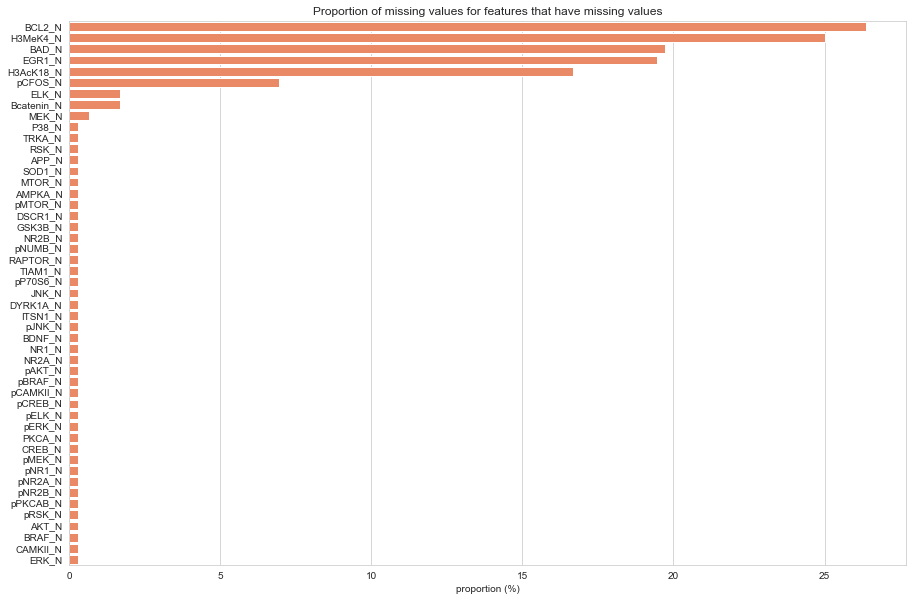

In [81]:
mv.barplot_mv(15, 10)

In [82]:
missing_values_per_row = df_X.isna().sum(axis=1)
missing_values_per_row[missing_values_per_row > 5]

MouseID
3426_13    43
3426_14    43
3426_15    43
dtype: int64

We will drop the rows that have missing values for 43 of the features

In [83]:
df_X.drop(list(missing_values_per_row[missing_values_per_row == 43].index), axis=0, inplace=True)

Impute with median

In [84]:
for col in list(mv.features_mv_only()):
    df_X[col].fillna(df_X[col].median(), inplace=True)

In [85]:
df_X.isna().sum().sum()

0

## 1.3 Scaling

In [86]:
from sklearn.preprocessing import StandardScaler

df_X = pd.DataFrame(StandardScaler().fit_transform(df_X), index=df_X.index, columns=df_X.columns)

## 1.4 t-SNE

In [87]:
from sklearn.manifold import TSNE

In [88]:
t_sne = TSNE(n_components=2, n_jobs=-1, learning_rate='auto', init='pca', random_state=23)
df_X_reduced = pd.DataFrame(t_sne.fit_transform(df_X), columns=['c1', 'c2'], index=df_X.index)

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


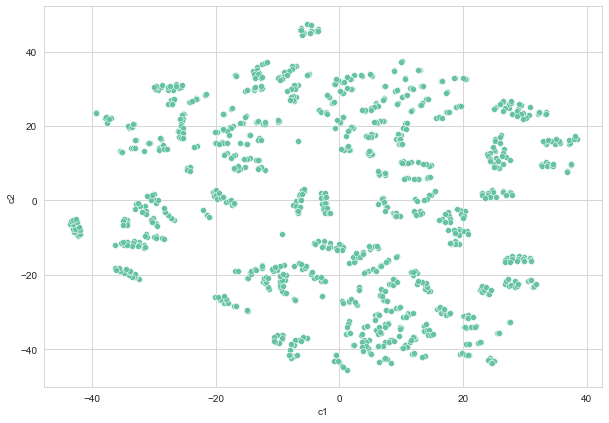

In [89]:
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_X_reduced, x='c1', y='c2')
plt.show()

# 2. GMM

In [90]:
from sklearn.mixture import GaussianMixture

In [91]:
n_components_range = range(1, 11)
gmm_results = {col: [] for col in ['num_clusters', 'BIC', 'CV']}
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        gmm = GaussianMixture(n_components=n_components, covariance_type=cv_type, init_params='kmeans', random_state=32)
        gmm.fit(df_X)

        gmm_results['num_clusters'].append(n_components)
        gmm_results['BIC'].append(gmm.bic(df_X))
        gmm_results['CV'].append(cv_type)

gmm_results = pd.DataFrame(gmm_results)

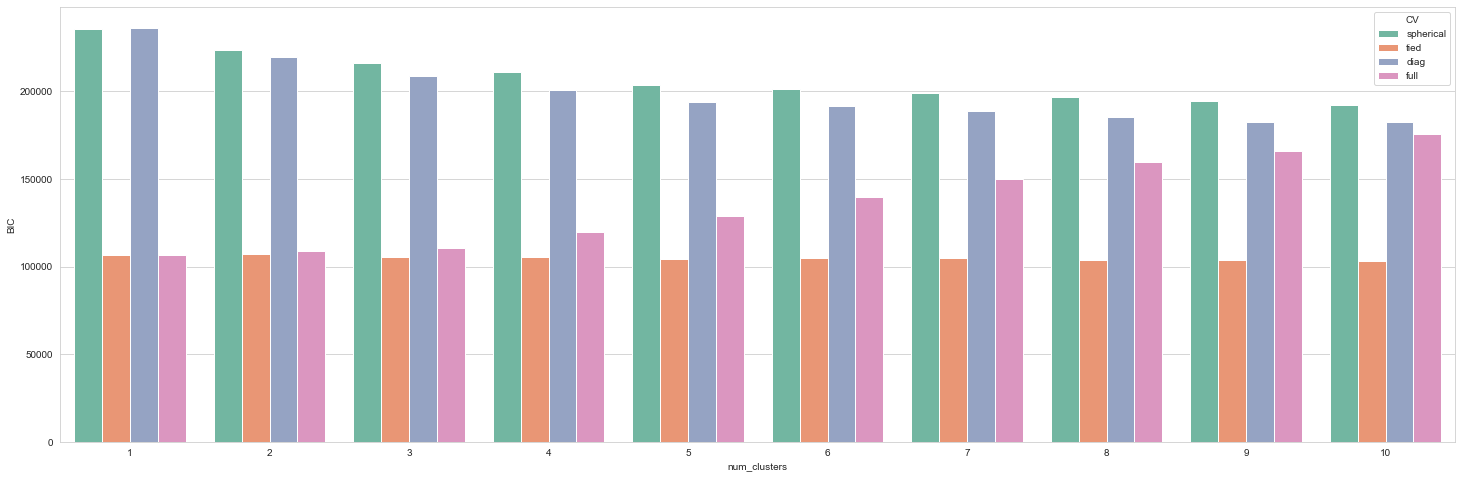

In [92]:
plt.figure(figsize=(25, 8))
sns.barplot(data=gmm_results, x='num_clusters', y='BIC', hue='CV')
plt.show()

In [93]:
gmm_results.sort_values(by='BIC', ascending=True).head(5)

,num_clusters,BIC,CV
19,10,103228.611770,tied
18,9,103695.270787,tied
17,8,103729.825828,tied
14,5,104529.562454,tied
16,7,105087.660441,tied


Since the outcomes of the score for 8, 9, and 10 clusters were very alike, we chose to go with 8 clusters.

In [94]:
gmm = GaussianMixture(n_components=8, covariance_type='tied', init_params='kmeans', random_state=32)
cluster_gmm = pd.Series(gmm.fit_predict(df_X), index=df_X.index)
cluster_gmm.name = 'cluster'

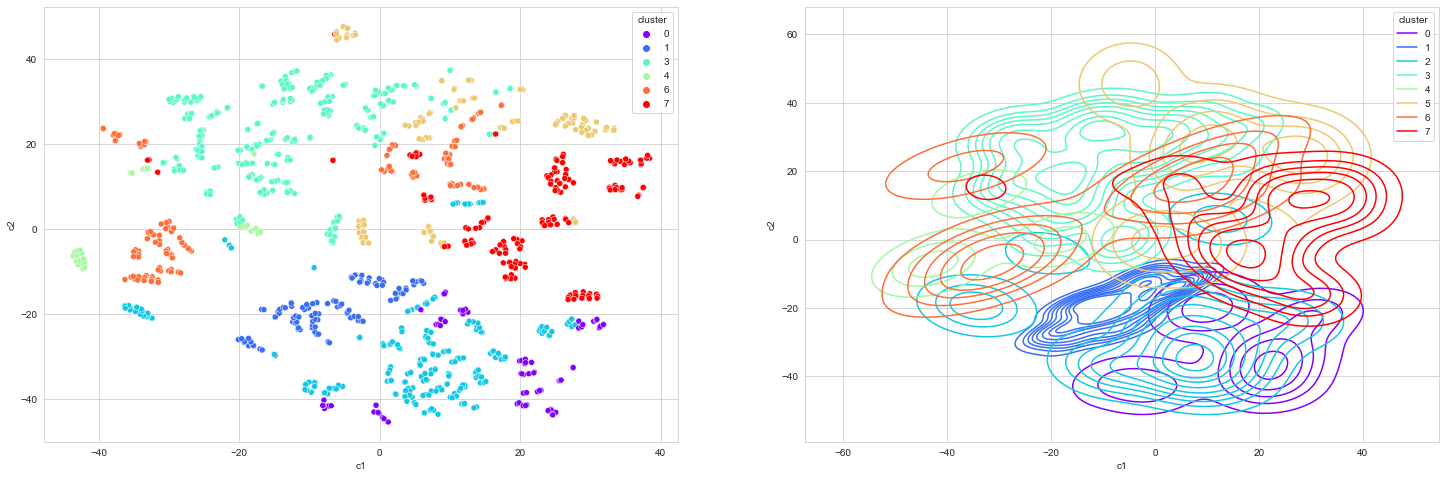

In [95]:
_, axs = plt.subplots(1, 2, figsize=(25, 8))
sns.scatterplot(data=df_X_reduced.join(cluster_gmm, on='MouseID', how='inner'), x='c1', y='c2', hue='cluster', palette='rainbow', ax=axs[0],)
sns.kdeplot(data=df_X_reduced.join(cluster_gmm, on='MouseID', how='inner'), x='c1', y='c2', hue='cluster', palette='rainbow', ax=axs[1])
plt.show()

# 3. Hierarchical Clustering

The reason we will be using ward linkage is that it can better handle outliers and clusters with varying densities.

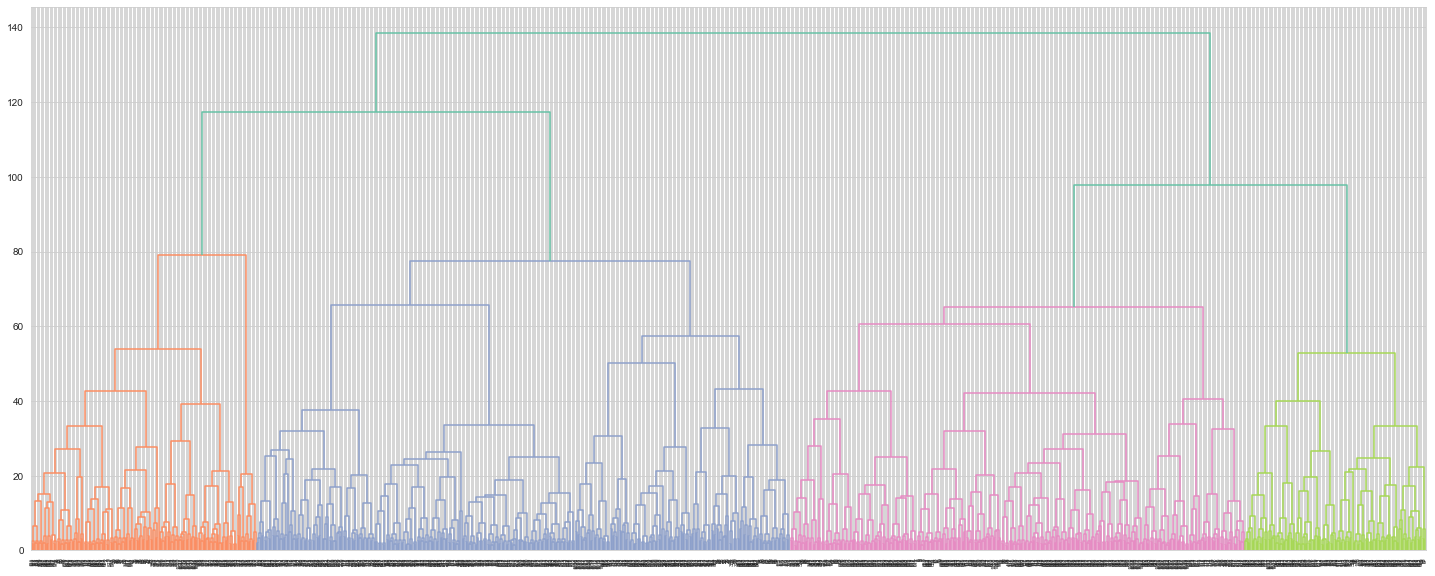

In [96]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

linked = linkage(df_X, 'ward')

plt.figure(figsize=(25, 10))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
plt.show()

Based on the dendrogram, a suitable range for selecting the number of clusters would be from 2 to 6.

In [97]:
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score
from sklearn.cluster import AgglomerativeClustering

ac_results = {col: [] for col in ['num_clusters', 'CH', 'Silhouette', 'DB']}
for i in range(2, 11):
    ac = AgglomerativeClustering(n_clusters=i, affinity='euclidean', linkage='ward')
    labels = ac.fit_predict(df_X)

    ac_results['num_clusters'].append(i)
    ac_results['CH'].append(calinski_harabasz_score(df_X, labels))
    ac_results['Silhouette'].append(silhouette_score(df_X, labels))
    ac_results['DB'].append(davies_bouldin_score(df_X, labels))

ac_results = pd.DataFrame(ac_results)

In [98]:
ac_results.index = ac_results['num_clusters']
ac_results.drop('num_clusters', axis=1, inplace=True)

The Silhouette coefficient suggests that 6 clusters would be a suitable choice, but the Davies Bouldin Index suggests that the optimal number of clusters should be somewhere between 5 to 8.

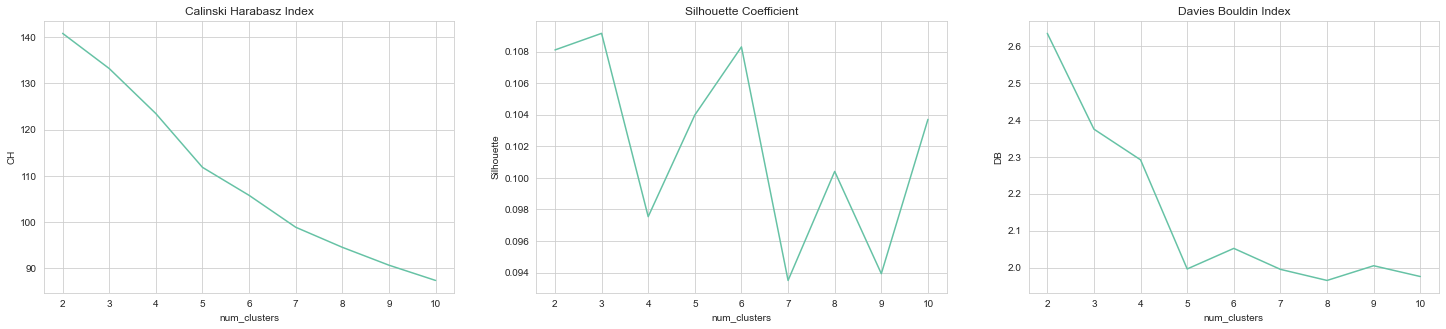

In [99]:
_, axs = plt.subplots(1, 3, figsize=(25, 5))

cols_labels = [('CH', 'Calinski Harabasz Index'), ('Silhouette', 'Silhouette Coefficient'), ('DB', 'Davies Bouldin Index')]
for i, (key, title) in enumerate(cols_labels):
    sns.lineplot(data=ac_results[key], ax=axs[i])
    axs[i].set_title(title)

plt.show()

In [100]:
ac_1 = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')
cluster_ac_1 = pd.Series(ac_1.fit_predict(df_X), index=df_X.index)
cluster_ac_1.name = 'cluster'

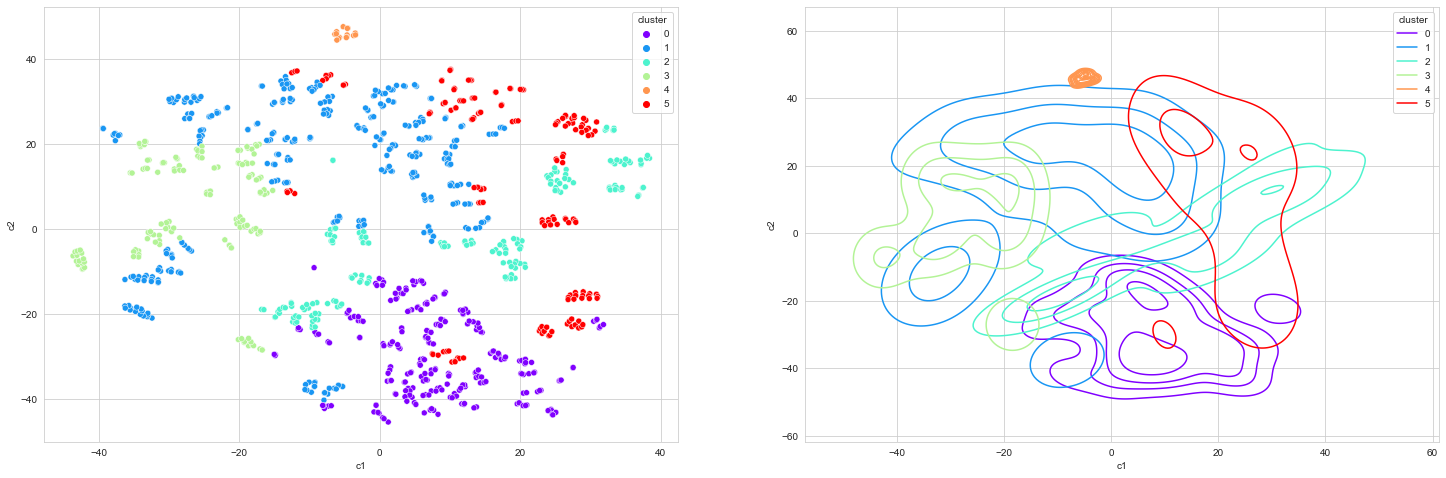

In [101]:
_, axs = plt.subplots(1, 2, figsize=(25, 8))
sns.scatterplot(data=df_X_reduced.join(cluster_ac_1, on='MouseID', how='inner'), x='c1', y='c2', hue='cluster', palette='rainbow', ax=axs[0])
sns.kdeplot(data=df_X_reduced.join(cluster_ac_1, on='MouseID', how='inner'), x='c1', y='c2', hue='cluster', palette='rainbow', ax=axs[1])
plt.show()

# 4. Comparing results with ground truth

In [102]:
from sklearn.metrics import v_measure_score

true_labels = df.loc[df_X.index, 'class']

print('V measure score for:')
print(f'                    GMM: {v_measure_score(true_labels, cluster_gmm)}')
print(f'Hierarchical Clustering: {v_measure_score(true_labels, cluster_ac_1)}')

V measure score for:
                    GMM: 0.4009709039550847
Hierarchical Clustering: 0.2225496317806175


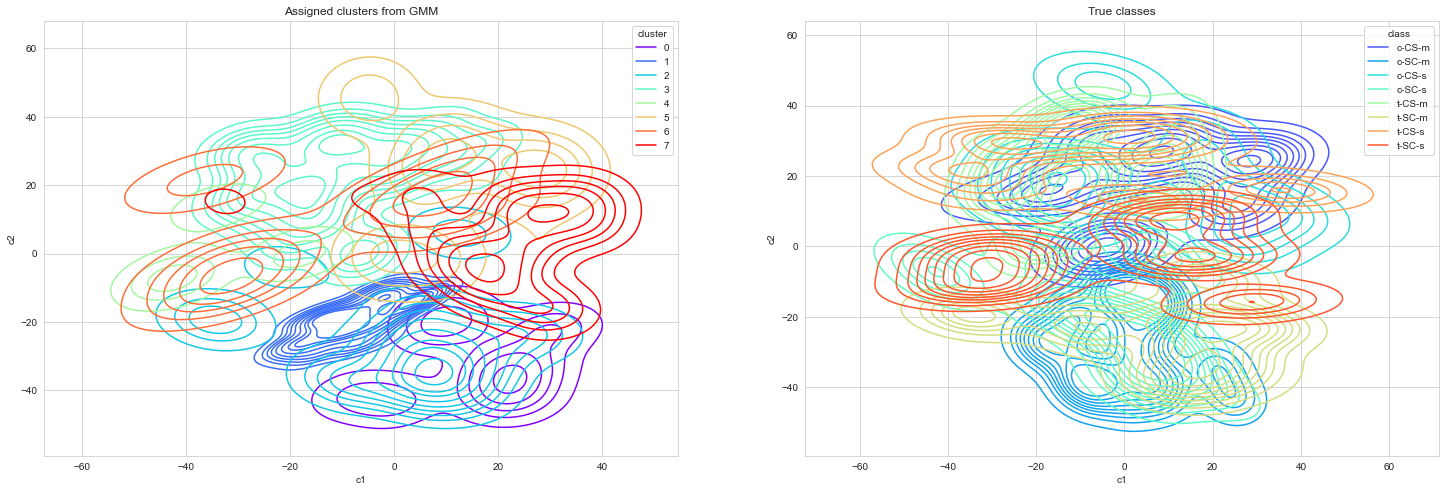

In [103]:
_, axs = plt.subplots(1, 2, figsize=(25, 8))
sns.kdeplot(data=df_X_reduced.join(cluster_gmm, on='MouseID', how='inner'), x='c1', y='c2', hue='cluster', palette='rainbow', ax=axs[0])
axs[0].set_title('Assigned clusters from GMM')
sns.kdeplot(data=df_X_reduced.join(true_labels, on='MouseID', how='inner'), x='c1', y='c2', hue='class', palette='rainbow', ax=axs[1])
axs[1].set_title('True classes')
plt.show()

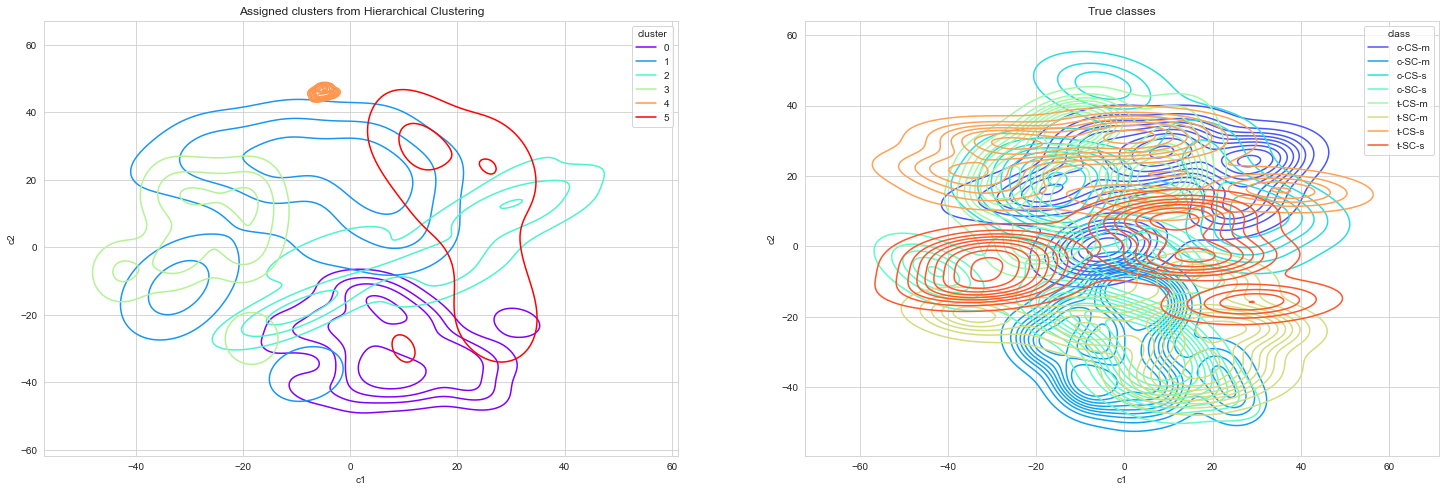

In [104]:
_, axs = plt.subplots(1, 2, figsize=(25, 8))
sns.kdeplot(data=df_X_reduced.join(cluster_ac_1, on='MouseID', how='inner'), x='c1', y='c2', hue='cluster', palette='rainbow', ax=axs[0])
axs[0].set_title('Assigned clusters from Hierarchical Clustering')
sns.kdeplot(data=df_X_reduced.join(true_labels, on='MouseID', how='inner'), x='c1', y='c2', hue='class', palette='rainbow', ax=axs[1])
axs[1].set_title('True classes')
plt.show()